# Libraries

In [1]:
from functions import *

# Generate cross section

In [2]:
# generate_cross_section(img_w_mm=75, img_h_mm=75, n_s=300)


In [3]:
import json

b = 150
h = 300
divs_b = 2
divs_h = 2

img_w_mm = b / divs_b
img_h_mm = h / divs_h
img_w_px = img_w_mm * 2500 / 75
img_h_px = img_h_mm * 2500 / 75

x_ini = [0, img_w_px, img_w_px, 0]
y_ini = [0, 0, img_h_px, img_h_px]

# acumulador final
all_contours = {}
contour_id = 1  # contador global para IDs

print("\nIniciando loop de geração de contornos...")
for i in range(divs_b * divs_h):
    dx = img_w_px * (i % divs_b)
    dy = img_h_px * (i // divs_b)
    
    print(f"\nProcessando retângulo {i+1} de {divs_b * divs_h}...")
    print(f"  - Posição: ({dx:.2f}, {dy:.2f})")
    
    # coordenadas do retângulo
    x, y = trans_polygon_to_x_y(x_ini, y_ini, dx, dy)
    del x[-1]
    del y[-1]
    
    # gera contornos para esse retângulo (coordenadas relativas ao retângulo)
    co = generate_cross_section(x_list=x, y_list=y, n_s=400)
    
    # ajusta coordenadas para posição global e adiciona ao acumulador
    for _, contour in co.items():
        xs = [xx for xx in contour["x coordinate"]]
        ys = [yy for yy in contour["y coordinate"]]
        
        all_contours[f"{contour_id:02}"] = {
            "x coordinate": xs,
            "y coordinate": ys
        }
        contour_id += 1

print("\nGeração de contornos concluída!")
print(f"Total de contornos gerados: {contour_id - 1}")

# salva o JSON final
print("\nSalvando arquivo JSON...")
with open("all_contours.json", "w") as f:
    json.dump(all_contours, f, indent=2)
print("Arquivo JSON salvo com sucesso!")

print("\nLimpando contornos duplicados...")
all_contours_clean = clean_contour_into_other_contour(all_contours)
print(f"Contornos após limpeza: {len(all_contours_clean)}")

print("\nVerificando contornos sobrepostos...")
overlapping_contourns = check_overlapping_contours(all_contours_clean)

# --- Salva JSON final limpo ---
with open("all_contours_clean.json", "w") as f:
    json.dump(all_contours_clean, f, indent=2)



print("Arquivo JSON limpo salvo com sucesso como 'all_contours_clean.json'!")



Iniciando loop de geração de contornos...

Processando retângulo 1 de 4...
  - Posição: (0.00, 0.00)

Processando retângulo 2 de 4...
  - Posição: (2500.00, 0.00)

Processando retângulo 3 de 4...
  - Posição: (0.00, 5000.00)

Processando retângulo 4 de 4...
  - Posição: (2500.00, 5000.00)

Geração de contornos concluída!
Total de contornos gerados: 1556

Salvando arquivo JSON...
Arquivo JSON salvo com sucesso!

Limpando contornos duplicados...
Contornos após limpeza: 1456

Verificando contornos sobrepostos...

🔎 Total de pares de contornos sobrepostos: 0
Arquivo JSON limpo salvo com sucesso como 'all_contours_clean.json'!


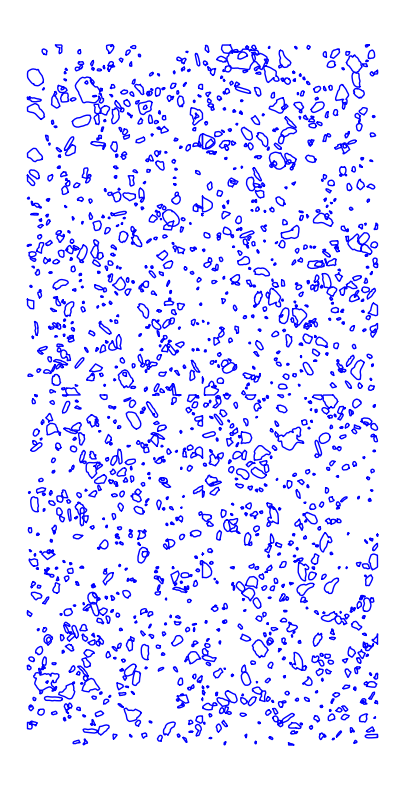

In [4]:
import json
import matplotlib.pyplot as plt

# === Ler o JSON final ===
with open("all_contours.json", "r") as f:
    all_contours = json.load(f)

# === Criar figura ===
fig, ax = plt.subplots(figsize=(10, 10))

# Plotar cada contorno branco com o fundo preto
for cont_id, cont_data in all_contours.items():
    xs = cont_data["x coordinate"]
    ys = cont_data["y coordinate"]
    ax.plot(xs, ys, color='blue', linewidth=1)
    # ax.fill(xs, ys, color='blue')

# Ajustar eixos
ax.set_aspect('equal', adjustable='box')  # escala 1:1
ax.invert_yaxis()  # opcional: se a origem (0,0) for no topo
ax.axis('off')

plt.show()


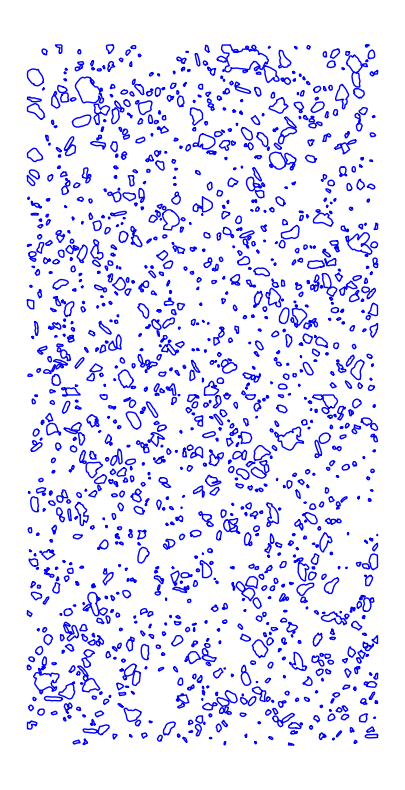

In [5]:
import json
import matplotlib.pyplot as plt

# === Ler o JSON final ===
with open("all_contours_clean.json", "r") as f:
    all_contours = json.load(f)

# === Criar figura ===
fig, ax = plt.subplots(figsize=(10, 10))

# Plotar cada contorno branco com o fundo preto
for cont_id, cont_data in all_contours.items():
    xs = cont_data["x coordinate"]
    ys = cont_data["y coordinate"]
    ax.plot(xs, ys, color='blue', linewidth=1)
    # ax.fill(xs, ys, color='blue')

# Ajustar eixos
ax.set_aspect('equal', adjustable='box')  # escala 1:1
ax.invert_yaxis()  # opcional: se a origem (0,0) for no topo
ax.axis('off')

plt.show()


In [7]:
import json
import matplotlib.pyplot as plt

# pares sobrepostos que você já achou
overlap_pairs = overlapping_contourns

# --- Carregar JSON ---
with open("all_contours_clean.json", "r") as f:
    contours = json.load(f)

# --- Plotar ---
plt.figure(figsize=(8, 8))
colors = ["red", "blue", "green", "orange", "purple", "cyan"]

if overlap_pairs == 0:
    print("Nenhum par de contornos sobrepostos encontrado.")

else:
    for pair in overlap_pairs:
        for k in pair:
            if str(k) in contours:
                x = contours[str(k)]["x coordinate"]
                y = contours[str(k)]["y coordinate"]
                plt.plot(x, y, color=colors[pair[0] % len(colors)])

    plt.gca().set_aspect("equal", adjustable="box")
    plt.title("Contornos Sobrepostos")
    plt.show()


Nenhum par de contornos sobrepostos encontrado.


<Figure size 800x800 with 0 Axes>

In [ ]:
b = 150
h = 300

divs_b = 2
divs_h = 2
img_w_mm = b / divs_b
img_h_mm = h / divs_h
img_w_px = img_w_mm * 2500 / 75
img_h_px = img_h_mm * 2500 / 75

x_ini = [0, img_w_px, img_w_px, 0]
y_ini = [0, 0, img_h_px, img_h_px]


for i in range(divs_b * divs_h):
    x, y = trans_polygon_to_x_y(x_ini, y_ini, img_w_px * (i % divs_b), img_h_px * (i // divs_b))
    del x[-1]
    del y[-1]
    co = generate_cross_section(x_list=x, y_list=y, n_s=400)

# box = []
# cont_h = 0
# cont_b = 0
# for i in range(b):
#     for j in range(h):
#         box.append([[cont_b, cont_h], [img_w_px, img_h_px]])
#         cont_h += img_h_px
#     cont_h = 0
#     cont_b += img_w_px

# box
# for i in range(divs_b * divs_h):

#     generate_cross_section(img_w_mm=img_w_px, img_h_mm=img_h_px, n_s=300, output_json=f"output_contour_{i}.json")

# co

In [ ]:
# import numpy as np
# from scipy.spatial import KDTree

# # 1. Create some sample data points in a 2D space
# data_points = np.array([
#     [1, 1],
#     [2, 1],
#     [3, 1],
#     [1, 2],
#     [2, 2],
#     [3, 2],
#     [1, 3],
#     [2, 3],
#     [3, 3]
# ])

# # 2. Build the KDTree from the data points
# tree = KDTree(data_points)

# # 3. Define a query point
# query_point = np.array([1.5, 1.5])

# points_within_radius_indices = tree.query_ball_point(query_point, r=1.5)

# print(f"\nIndices of points within radius 1.5 of {query_point}: {points_within_radius_indices}")
# print(f"Points within radius 1.5:\n{data_points[points_within_radius_indices]}")


Indices of points within radius 1.5 of [1.5 1.5]: [0, 1, 3, 4]
Points within radius 1.5:
[[1 1]
 [2 1]
 [1 2]
 [2 2]]


In [ ]:
# import numpy as np
# from scipy.spatial import cKDTree  # mais rápido que KDTree

# # Exemplo de entrada (lista de arrays Nx2)
# data_points = [
#     np.array([[1,1],[2,1],[3,1],[1,2],[2,2],[3,2],[1,3],[2,3],[3,3]]),
#     np.array([[10,10],[11,10],[10,11]])
# ]

# # Pré-processamento: 1 índice por grupo
# trees = [cKDTree(arr) for arr in data_points]
# print(trees)

# def groups_within_radius(point, r):
#     """Retorna os índices dos grupos (itens da lista) com vizinhos no raio r do ponto."""
#     hits = []
#     for i, t in enumerate(trees):
#         if len(t.data) == 0:
#             continue
#         idxs = t.query_ball_point(point, r)
#         if idxs:
#             hits.append(i)
#     return hits

# # Uso
# q = np.array([12, 12])
# r = 1.5
# j = groups_within_radius(q, r)
# print(j, len(j))  # ex.: [0]


[<scipy.spatial._ckdtree.cKDTree object at 0x0000025ECE701FC0>, <scipy.spatial._ckdtree.cKDTree object at 0x0000025ECE701BD0>]
[] 0


In [ ]:
# from shapely.geometry import Polygon
# from shapely.affinity import translate

# # === 1. Retângulo original: 4 vértices ===
# # Exemplo: (xmin, ymin), (xmax, ymin), (xmax, ymax), (xmin, ymax)
# vertices = [(0, 0), (4, 0), (4, 3), (0, 3)]
# rect = Polygon(vertices)

# print("Original:", list(rect.exterior.coords))

# # === 2. Translação ===
# # dx = deslocamento no eixo X
# # dy = deslocamento no eixo Y
# dx = 10
# dy = -5

# rect_translated = translate(rect, xoff=dx, yoff=dy)

# print("Transladado:", list(rect_translated.exterior.coords))


Original: [(0.0, 0.0), (4.0, 0.0), (4.0, 3.0), (0.0, 3.0), (0.0, 0.0)]
Transladado: [(10.0, -5.0), (14.0, -5.0), (14.0, -2.0), (10.0, -2.0), (10.0, -5.0)]


In [ ]:
# div = 2
# df = sort_contours_using_uniform_pdf_and_group("dataset_contours_aggregate_by_patch.csv", "dataset_contours_aggregate_by_patch.json", 4, div)
# df

# color = [
#             '#3a7b9f', '#d4e2c3', '#f0119b', '#a1c935', "#28f8a1",
#             '#ff9000', '#b04c87', '#52e0ff', '#6012ff', '#c0ffee',
#             '#123456', '#654321', '#ff00ff', '#00ff00', '#0000ff',
#             '#abcdef', '#fedcba', '#a0b1c2', '#1f2e3d', '#f0f8ff', '#3a7b9f',    
#         ]

In [ ]:
# img_w, img_h = 2500, 2500
# fig, ax = plt.subplots(figsize=(7, 7))
# ax.imshow(np.ones((img_h, img_w)), cmap="gray")
# for k in [1, 2, 3, 4, 5]:# , div+1):
#     df_group = df[df['group by diameter (px)'] == k].reset_index(drop=True)
#     target_size = df_group['diameter (px)'].max() + 50
#     nx = int(round(img_w / target_size))
#     ny = int(round(img_h / target_size))
#     cell_w = img_w / nx
#     cell_h = img_h / ny
#     centers = []
#     ids = []
#     if k > 1:
#         quad_contours = []
#     for j in range(ny):
#         for i in range(nx):
#             cx = (i + 0.5) * cell_w
#             cy = (j + 0.5) * cell_h
#             centers.append((cx, cy))
#             ids.append(j * nx + i)
#             if k > 1:
#                 # quad_contours.append([(cx - cell_w / 2, cy - cell_h / 2), (cx + cell_w / 2, cy - cell_h / 2), (cx + cell_w / 2, cy + cell_h / 2), (cx - cell_w / 2, cy + cell_h / 2)])
#                 n = 5
#                 quad_contours.append([(cx - (cell_w-n) / 2, cy - (cell_h-n) / 2), (cx + (cell_w-n) / 2, cy - (cell_h-n) / 2), (cx + (cell_w-n) / 2, cy + (cell_h-n) / 2), (cx - (cell_w-n) / 2, cy + (cell_h-n) / 2)])
#     center_ids_selected = np.random.choice(ids, size=len(df_group), replace=False)
#     centers = np.array(centers)

#     # Check colision
#     if k > 1:
#         colision_bin = [0] * len(quad_contours)
#         for i, quad in enumerate(quad_contours):
#             quad_poly = sh.geometry.Polygon(quad)
#             for cont in contours:
#                 if quad_poly.intersects(sh.geometry.Polygon(cont)):
#                     colision_bin[i] = 1
#                     break
#         ids_temp = [i for i in range(len(quad_contours)) if colision_bin[i] == 0]
#         if len(ids_temp) < len(df_group):
#             center_ids_selected = np.random.choice(ids_temp, size=len(ids_temp), replace=False)
#         else:
#             center_ids_selected = np.random.choice(ids_temp, size=len(df_group), replace=False)

#     if k == 4:
#         for i in range(nx + 1):
#             x = i * cell_w
#             ax.axvline(x, color='blue', linewidth=1)
#         for j in range(ny + 1):
#             y = j * cell_h
#             ax.axhline(y, color='blue', linewidth=1)
#     if k <= 1:
#         contours = []
#     for m, row in df_group.iterrows():
#         print(m)
#         x_df = row['x coordinate in 0,0']
#         y_df = row['y coordinate in 0,0']
#         cx, cy = centers[center_ids_selected[m], 0], centers[center_ids_selected[m], 1]
#         cx_noise = noise_point([cx], value_noise=1)
#         cy_noise = noise_point([cy], value_noise=1)
#         ax.scatter(cx_noise, cy_noise, c='red', s=2)
#         x_new, y_new = trans_rota_polygon(x_df, y_df, cx_noise[0], cy_noise[0], angle=np.random.uniform(0, 360))
#         contours.append(list(zip(x_new, y_new)))
#         ax.plot(x_new, y_new, color[k])
#         ax.fill(x_new, y_new, color[k], alpha=0.3)
# plt.show()

In [ ]:
# img_w, img_h = 140, 400

# # Dataset extract
# df = sort_contours_using_uniform_pdf_and_group("dataset_contours_aggregate_by_patch.csv", "dataset_contours_aggregate_by_patch.json", 350)

# # Convert mm to px
# img_w = img_w * 2500 / 75
# img_h = img_h * 2500 / 75

# # Start process
# fig, ax = plt.subplots(figsize=(14, 40))
# retan = patches.Rectangle((0, 0), img_w, img_h, 
#                              linewidth=2, edgecolor='r', 
#                              facecolor='gray', alpha=0.5)
# contours = []
# collision_control = []
# for m, row in df.iterrows():
#     if m < 1:
#         n = 1
#         sampler = sc.stats.qmc.LatinHypercube(d=2)
#         sample = sampler.random(n=n)
#         centroids = sc.stats.qmc.scale(sample, [0, 0], [img_w, img_h])
#         x_df = row['x coordinate in 0,0']
#         y_df = row['y coordinate in 0,0']
#         cx, cy = centroids[0, 0], centroids[0, 1]
#         cx_noise = noise_point([cx], value_noise=1)
#         cy_noise = noise_point([cy], value_noise=1)
#         x_new, y_new = trans_rota_polygon(x_df, y_df, cx_noise[0], cy_noise[0], angle=np.random.uniform(0, 360))
#         current_contour = list(zip(x_new, y_new))
#         contours.append(current_contour)
#         ax.scatter(cx_noise, cy_noise, c='red', s=2)
#         ax.plot(x_new, y_new)
#         ax.fill(x_new, y_new, alpha=0.3)
#     else:
#         th = True
#         max_iter = 0
#         while th and max_iter < 100:
#             # print("max_iter:", max_iter)
#             n = 1
#             sampler = sc.stats.qmc.LatinHypercube(d=2)
#             sample = sampler.random(n=n)
#             centroids = sc.stats.qmc.scale(sample, [0, 0], [img_w, img_h])
#             x_df = row['x coordinate in 0,0']
#             y_df = row['y coordinate in 0,0']
#             cx, cy = centroids[0, 0], centroids[0, 1]
#             cx_noise = noise_point([cx], value_noise=2)
#             cy_noise = noise_point([cy], value_noise=2)
#             x_new, y_new = trans_rota_polygon(x_df, y_df, cx_noise[0], cy_noise[0], angle=np.random.uniform(0, 360))
#             current_contour = list(zip(x_new, y_new))
#             for _, quad in enumerate([current_contour]):
#                 quad_poly = sh.geometry.Polygon(quad)
#                 for cont in contours:
#                     th = quad_poly.intersects(sh.geometry.Polygon(cont))
#                     # print("th:", th)
#                     if th:
#                         # print("Collision detected, retrying...")
#                         break
#             if th==False:
#                 # print("passei aqui no False th...")
#                 contours.append(current_contour)
#                 ax.scatter(cx_noise, cy_noise, c='red', s=2)
#                 ax.plot(x_new, y_new)
#                 ax.fill(x_new, y_new, alpha=0.3)
#                 break
#             else:
#                 # print("Another try...")
#                 pass
#             max_iter += 1
# ax.add_patch(retan)  
# plt.savefig('viga.png', dpi=300, bbox_inches='tight')  # Formato PNG
# plt.show()

In [ ]:
# # For que realiza o recorte dos contornos
# new_contours = []
# for cont in contours:
#     xs, ys = zip(*cont)
#     xs = np.array(xs)
#     ys = np.array(ys)

#     # Verifica se TODOS os pontos estão fora 
#     all_out_x = np.all((xs < 0) | (xs > img_w))
#     all_out_y = np.all((ys < 0) | (ys > img_h))
#     if all_out_x or all_out_y:
#         # Remove o contorno completamente
#         continue
    
#     # Limita os pontos para a borda
#     xs_clipped = np.clip(xs, 0, img_w)
#     ys_clipped = np.clip(ys, 0, img_h)

#     clipped_contour = list(zip(xs_clipped, ys_clipped))
#     new_contours.append(clipped_contour)


In [ ]:
# import matplotlib.pyplot as plt

# fig, ax = plt.subplots(figsize=(7, 7))
# ax.imshow(np.ones((int(img_h), int(img_w))), cmap="gray")  # Fundo branco (1 = branco em cmap gray)

# for cont in new_contours:
#     xs, ys = zip(*cont)
#     ax.plot(xs, ys, color='blue')
#     ax.fill(xs, ys, alpha=0.3, color='cyan')

# ax.set_xlim(0, img_w)
# ax.set_ylim(img_h, 0)  # Inverte eixo y para imagem ficar "normal"
# ax.axis('off')  # Opcional, para esconder os eixos

# plt.show()

# Gross section generator

In [ ]:
# generate_canvas_from_json("dataset_contours_aggregate_by_patch.json", (2500, 2500), 300)

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import shapely as sh
# import scipy as sc
# import json



